### Input Example

In [1]:
from torch_geometric.data import Data
import torch

x = torch.ones(3, 30, dtype=torch.float)
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
mwt = torch.tensor([[230.]], dtype=torch.float)

dataset_input = {
    'MolToGraphFeaturizer': Data(x=x, edge_index=edge_index, batch=None), # Batch is filled when 
                                                                          # sampled from a pyg DataLoader?
    'mwt': mwt
}
dataset_input

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'MolToGraphFeaturizer': Data(x=[3, 30], edge_index=[2, 4]),
 'mwt': tensor([[230.]])}

### Custom Dataset

In [2]:
from typing import Union, List
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset as nnDataset
from app.features.dataset.model import Dataset
from app.features.model.schema.configs import ModelConfig

def if_str_make_list(str_or_list: Union[str, List[str]]) -> List[str]:
    if isinstance(str_or_list, str):
        return [str_or_list]
    return str_or_list

class CustomDataset(nnDataset):
    def __init__(self, dataset: Dataset, model_config: ModelConfig):
        super().__init__()
        self.dataset = dataset
        self.model_config = model_config
        self.df = dataset.get_dataframe()
        # maps featurizer name to actual featurizer instance
        self.featurizers_dict = { f.name: f.create() for f in model_config.featurizers }
        # maps featurizer name to featurizer config
        self.featurizer_configs = { f.name: f for f in model_config.featurizers }
        
    def __len__(self):
        return len(self.df)
    
    def get_not_featurized(self):
        is_col_featurized = {
            col: False 
            for col in self.model_config.dataset.feature_columns
        }
        for feat_config in self.featurizer_configs.values():
            inputs = if_str_make_list(feat_config.input)
            for input in inputs:
                is_col_featurized[input] = True
        not_featurized = [
            col
            for col, is_featurized in is_col_featurized.items()
            if not is_featurized
        ]
        return not_featurized

    def __getitem__(self, idx):
        sample = {}
        target_column = self.model_config.dataset.target_column
        y = torch.Tensor([self.df.loc[idx, [target_column]]])
        not_featurized_cols = self.get_not_featurized()
        for column in not_featurized_cols:
            # TODO, validate columns. For now assuming are all scalars
            sample[column] = torch.Tensor([self.df.loc[idx, column]])
        for feat_name, feat in self.featurizers_dict.items():
            feat_config = self.featurizer_configs[feat_name]
            inputs = if_str_make_list(feat_config.input)
            assert len(inputs) == 1, "Only featurizers with a single input for now"
            sample[feat_name] = feat(self.df.loc[idx, inputs[0]])
        
        return sample, y


/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Parse model config yaml file

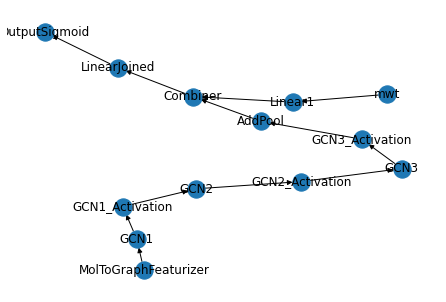

In [3]:
import networkx as nx
import yaml


config = """name: GNNExample
dataset:
  name: Small Zinc dataset
  target_column: tpsa
  feature_columns:
    - smiles
    - mwt

featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false

layers:

  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 26
      out_channels: 64
    input: MolToGraphFeaturizer

  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1

  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2

  - name: GCN3
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3

  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
  # End of fst branch

  # Second branch would simply be linear layers in mwt
  - name: Linear1
    type: torch.nn.Linear
    args:
      in_features: 1
      out_features: 10
    input: mwt

  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['AddPool', 'Linear1']

  - name: LinearJoined
    type: torch.nn.Linear
    input: Combiner
    args:
      in_features: 74
      out_features: 1

  - name: OutputSigmoid
    type: torch.nn.Sigmoid
    input: LinearJoined
"""

model = ModelConfig.from_yaml(config)

nx.draw(model.make_graph(), with_labels=True)

In [4]:

## Creating the database dataset object
from fastapi.datastructures import UploadFile
from app.db.session import SessionLocal
from app.features.dataset import controller as dataset_ctl
from app.features.dataset.schema import DatasetCreate, Dataset
from app.features.dataset.crud import repo as dataset_repo
from app.features.user.crud import repo as user_repo

ds_file_path = '/app/app/tests/data/zinc.csv'
ds_file = open(ds_file_path, 'rb')
ds_file = UploadFile(ds_file_path, ds_file)
user = None
db = None
if not db:
    db = SessionLocal()
ds = dataset_repo.get_by_name(db, 'Small Zinc dataset')
if not user:
    user = user_repo.get_by_email(db, email='admin@mariner.trident.bio')
    assert user is not None
if not ds:
    ds = dataset_ctl.create_dataset(db, user, DatasetCreate(
        file=ds_file,
        name="Small Zinc dataset",
        description="The dataset with 1 smiles and 1 scalar columns as features and 1 scalar column as target",
        split_target="60-20-20"
    ))
    assert ds is not None
    
# creating pygnn dataset instance
dataset = CustomDataset(ds, model)
dataloader = DataLoader(dataset)
print(next(iter(dataloader)))

[{'mwt': tensor([[296.3670]]), 'MolToGraphFeaturizer': DataBatch(x=[21, 26], edge_index=[2, 42], edge_attr=[42, 9], batch=[21], ptr=[2])}, tensor([[[72.6400]]])]


In [5]:
import torch_geometric.nn as geom_nn
from torch.nn import ReLU, Sigmoid
from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat

edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )
activations = (ReLU, Sigmoid)

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

def is_graph_activation(layer, layers_dict, previous):
    """
    takes the a dictionary with nn.Modules and the keys of
    previous layers, checking if 
    """
    if not isinstance(layer, activations):
        return False
    for name in previous:
        if is_message_passing(layers_dict[name]) or is_graph_pooling(layers_dict[name]):
            return True
    return False


### Custom Model

In [6]:
# Implement module forward
from typing import Dict, Union, List
import torch
import torch.nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data

CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]

class CustomModel(torch.nn.Module):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
    
    def forward(self, input_: CustomDatasetIn):
        storage = input_.copy()

        for index, node_name in enumerate(self.topo_sorting):
            if not node_name in self.layers:
                continue
            layer_name = node_name
            layer = self.layers[layer_name]
            layer_config = self.layer_configs[layer_name]
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            inputs = if_str_make_list(layer_config.input)
            # Step 2
            # Transform and preprocess the input and output based on the previous
            # and next layers.
            
            if is_message_passing(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index = storage[src].x, storage[src].edge_index
                x, edge_index = layer(x=x, edge_index=edge_index), edge_index
                storage[layer_name] = Data(x=x, edge_index=edge_index)
            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object
            elif is_graph_pooling(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index, batch = storage[src].x, storage[src].edge_index, storage[src].batch
                storage[layer_name] = layer(x=x, batch=batch)
            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in t;he correct format
            #         and check the next layers to format the output
            elif is_graph_activation(layer, self.layers, previous_layers):
                assert len(inputs) == 1, f"Length of a activation layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index = storage[src].x, storage[src].edge_index
                storage[layer_name] = Data(x=layer(x), edge_index=edge_index)
            elif is_concat_layer(layer):
                assert len(inputs) == 2, f"Length of a concat layer's inputs should be 2. inputs = {inputs}"
                x1, x2 = storage[inputs[0]], storage[inputs[1]]
                storage[layer_name] = layer(x1,x2)
            else:
                input_values = [ 
                    storage[input] if isinstance(storage[input], Data) else
                    storage[input]
                    for input in inputs
                ]
                storage[layer_name] = layer(*input_values)
            last = storage[layer_name]
        return last
custom_model = CustomModel(model)
x, y = next(iter(dataloader))
custom_model.forward(x)

tensor([[0.9999]], grad_fn=<SigmoidBackward>)